# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import janitor

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
font = {"family": 'Arial'}
        #'size'   : 18}
#        'weight' : 'bold',}

matplotlib.rc('font', **font)

In [6]:
import spikeinterface

In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_560414/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [8]:
import spikeinterface.core

In [9]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [10]:
import spikeinterface.full as si

# Plotting Configurations

In [11]:
# Plot Specifics
TITLESIZE = 60
AXESLABEL = 60
AXESTICKS = 45
LINWID = 10
DOTS = 25
LEGSIZE = 45

# Reading in all the Wilcoxon Files

In [12]:
all_wilcoxon_path = glob.glob("./**/proc/*neuron_to_wilcoxon_df", recursive=True)

In [13]:
all_wilcoxon_df = [pd.read_csv(path, index_col=0) for path in all_wilcoxon_path]

In [14]:
combined_wilcoxon_df = pd.concat(all_wilcoxon_df).reset_index(drop=True)

In [15]:
combined_wilcoxon_df.head()

,loss,win,rewarded,omission,loss_pvalue,win_pvalue,rewarded_pvalue,omission_pvalue,subject_id,recording_date
0,"WilcoxonResult(statistic=63.0, pvalue=0.346549...","WilcoxonResult(statistic=0.0, pvalue=1.0)","WilcoxonResult(statistic=14.0, pvalue=0.1015625)","WilcoxonResult(statistic=3.0, pvalue=1.0)",0.346550,1.0,0.101562,1.000000,6.3,20221215
1,"WilcoxonResult(statistic=45.5, pvalue=0.241317...",NaN,"WilcoxonResult(statistic=8.5, pvalue=0.6706943...","WilcoxonResult(statistic=2.0, pvalue=0.75)",0.241317,NaN,0.670694,0.750000,6.3,20221215
2,"WilcoxonResult(statistic=45.5, pvalue=0.408397...","WilcoxonResult(statistic=0.0, pvalue=1.0)","WilcoxonResult(statistic=22.5, pvalue=0.413085...","WilcoxonResult(statistic=0.0, pvalue=0.3173105...",0.408397,1.0,0.413086,0.317311,6.3,20221215
3,"WilcoxonResult(statistic=38.0, pvalue=0.361500...","WilcoxonResult(statistic=0.0, pvalue=1.0)","WilcoxonResult(statistic=14.0, pvalue=0.309223...","WilcoxonResult(statistic=0.0, pvalue=0.25)",0.361501,1.0,0.309224,0.250000,6.3,20221215
4,"WilcoxonResult(statistic=67.5, pvalue=0.468292...","WilcoxonResult(statistic=0.0, pvalue=1.0)","WilcoxonResult(statistic=14.0, pvalue=0.168806...","WilcoxonResult(statistic=3.0, pvalue=1.0)",0.468292,1.0,0.168807,1.000000,6.3,20221215


# Pie Chart for Losing and Omission

In [16]:
p_value_threshold = 0.05

- Seeing how many neurons reacted to winning and being rewarded

In [17]:
reward_or_win_firing_rate_difference_count = {}
reward_or_win_firing_rate_difference_count["Win only"] = 0
reward_or_win_firing_rate_difference_count["Rewarded Alone only"] = 0
reward_or_win_firing_rate_difference_count["Rewarded Alone and Win"] = 0
reward_or_win_firing_rate_difference_count["No response"] = 0
for index, row in combined_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["Rewarded Alone and Win"] = reward_or_win_firing_rate_difference_count.get('Rewarded Alone and Win', 0) + 1
    # if one
    elif row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["Rewarded Alone only"] = reward_or_win_firing_rate_difference_count.get('Rewarded Alone only', 0) + 1

    # if other
    elif row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["Win only"] = reward_or_win_firing_rate_difference_count.get('Win only', 0) + 1
    else:
        reward_or_win_firing_rate_difference_count["No response"] = reward_or_win_firing_rate_difference_count.get("No response") + 1

In [18]:
reward_or_win_firing_rate_difference_count

{'Win only': 12,
 'Rewarded Alone only': 7,
 'Rewarded Alone and Win': 8,
 'No response': 31}

- Seeing how many neurons reacted to losing and omission of reward

In [19]:
omission_or_loss_firing_rate_difference_count = {}
omission_or_loss_firing_rate_difference_count["Omission Alone only"] = 0
omission_or_loss_firing_rate_difference_count["Loss only"] = 0
omission_or_loss_firing_rate_difference_count["Omission Alone and Loss"] = 0
omission_or_loss_firing_rate_difference_count["No Response"] = 0

for index, row in combined_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["Omission Alone and Loss"] = omission_or_loss_firing_rate_difference_count.get('Omission Alone and Loss', 0) + 1
    # if one
    elif row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["Omission Alone only"] = omission_or_loss_firing_rate_difference_count.get('Omission Alone only', 0) + 1

    # if other
    elif row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["Loss only"] = omission_or_loss_firing_rate_difference_count.get('Loss only', 0) + 1
    else:
        omission_or_loss_firing_rate_difference_count["No Response"] = omission_or_loss_firing_rate_difference_count["No Response"] = omission_or_loss_firing_rate_difference_count.get('No Response', 0) + 1

In [20]:
omission_or_loss_firing_rate_difference_count

{'Omission Alone only': 0,
 'Loss only': 2,
 'Omission Alone and Loss': 0,
 'No Response': 56}

- Creating a pie chart

In [21]:
reward_or_win_firing_rate_difference_count

{'Win only': 12,
 'Rewarded Alone only': 7,
 'Rewarded Alone and Win': 8,
 'No response': 31}

In [22]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''

In [23]:
def get_new_labels(sizes, labels):
    new_labels = [label if size > 1 else '' for size, label in zip(sizes, labels)]
    return new_labels

In [24]:
rewarded_patch = mpatches.Patch(color='#FFAF00', label='Rewarded only')
win_patch = mpatches.Patch(color="#15616F", label='Win only')
reward_and_win_patch = mpatches.Patch(color='#FEEDD3', label='Rewarded and Win')
none_patch = mpatches.Patch(color='#C5D7DB', label='No Response')
colors = ['#FFAF00', "#15616F", '#FEEDD3', '#C5D7DB']
all_patches = [rewarded_patch, win_patch, reward_and_win_patch, none_patch]

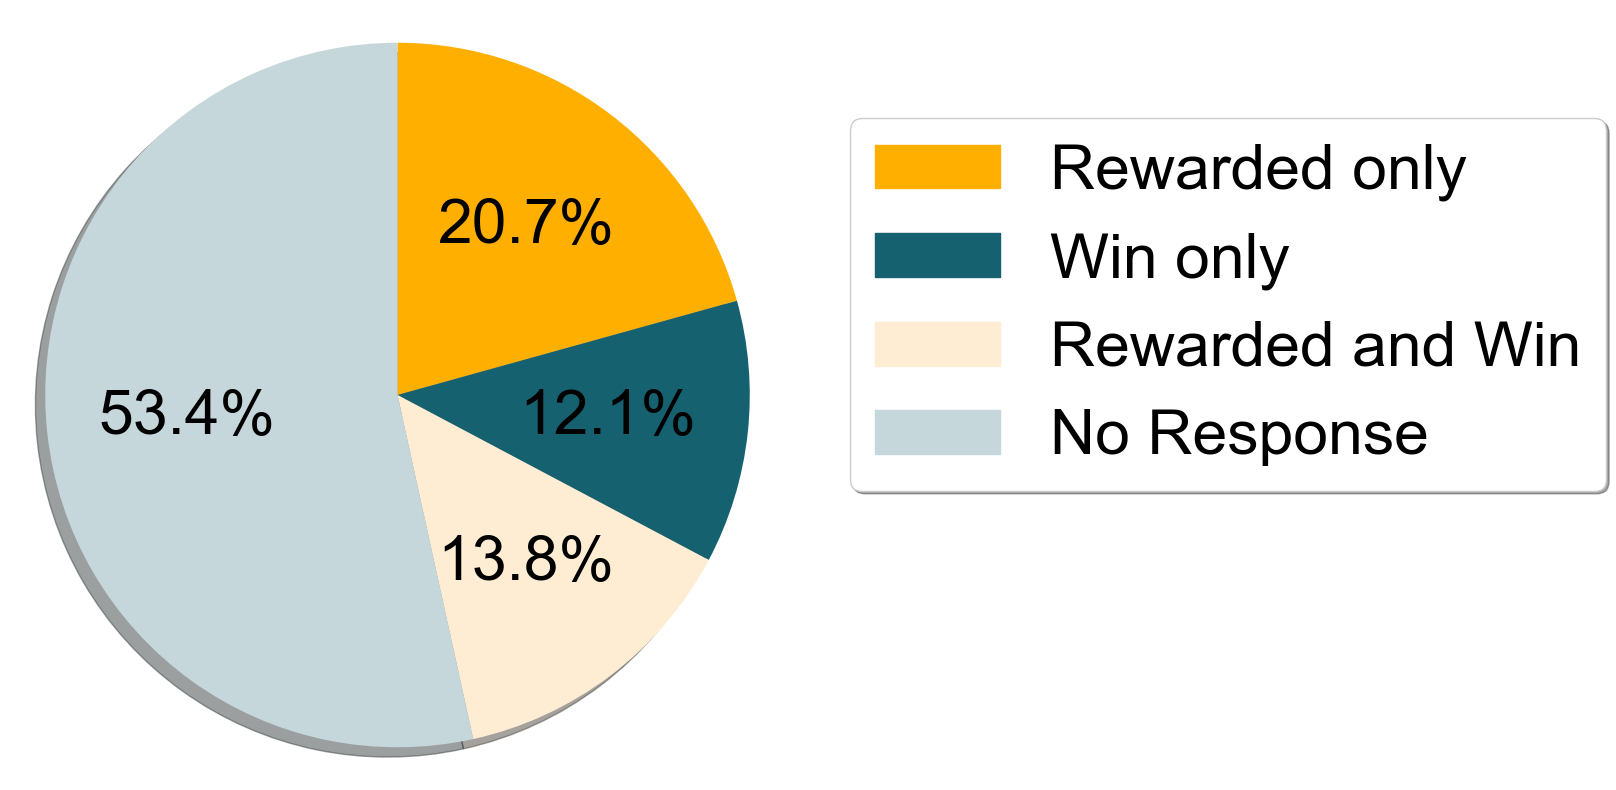

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.pie(reward_or_win_firing_rate_difference_count.values(), \
        labels=['','','',''], \
        autopct=my_autopct, \
        shadow=True, startangle=90, textprops={'fontsize': AXESTICKS}, colors=colors, pctdistance=0.6, counterclock=False)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.title("Subset of cells\nencode getting reward", fontsize = TITLESIZE)
plt.legend(handles=all_patches, loc="upper right", fancybox=True, shadow=True, fontsize=LEGSIZE, bbox_to_anchor=(2.1, 0.9))
# plt.tight_layout()
plt.savefig("./proc/plots/reward_and_win_pie_chart.png", bbox_inches='tight')
plt.savefig("./proc/plots/reward_and_win_pie_chart.png", bbox_inches='tight')
plt.show()

In [26]:
om_patch = mpatches.Patch(color='#001424', label='Omission only')
loss_patch = mpatches.Patch(color='#792910', label='Loss only')
om_and_loss_patch = mpatches.Patch(color='#FEEDD3', label='Omission and Loss')
none_patch = mpatches.Patch(color='#C5D7DB', label='No Response')
colors = ['#001424', '#792910', '#FEEDD3', '#C5D7DB']
all_patches = [om_patch, loss_patch, om_and_loss_patch, none_patch]

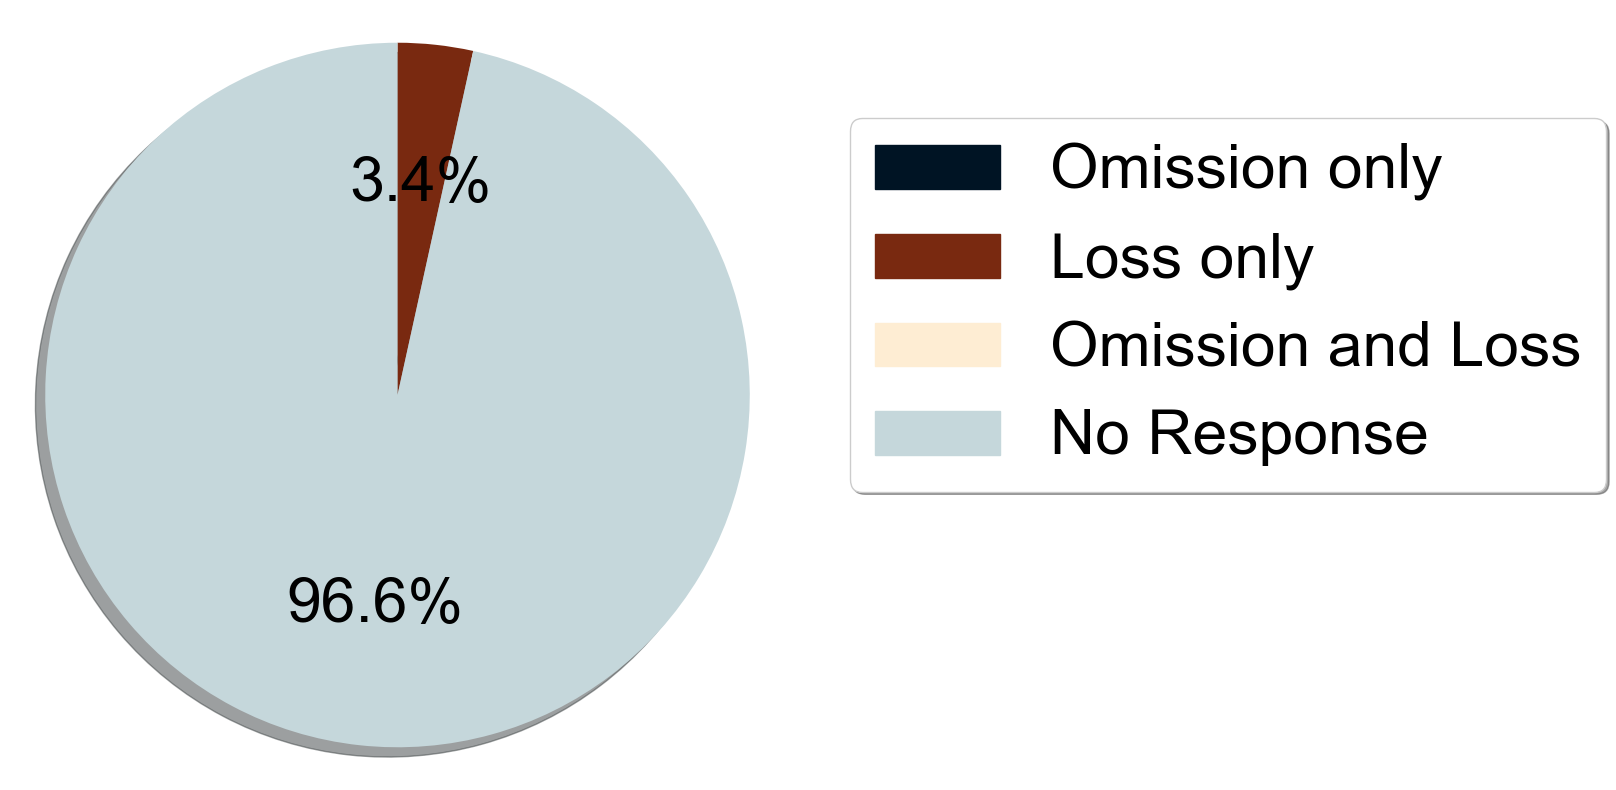

In [27]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots(figsize = (10,10))
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), \
        labels=['','','',''], \
        autopct=my_autopct, \
        shadow=True, startangle=90, textprops={'fontsize': AXESTICKS}, colors=colors, pctdistance=0.6, counterclock=False)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plt.title("Cells do not respond\nto omission of reward", fontsize = TITLESIZE)
plt.legend(handles=all_patches, loc="upper right", fancybox=True, shadow=True, fontsize=LEGSIZE, bbox_to_anchor=(2.1, 0.9))
# plt.tight_layout()
plt.savefig("./proc/plots/om_and_loss_pie_chart.png", bbox_inches='tight')
plt.savefig("./proc/plots/om_and_loss_pie_chart.svg", bbox_inches='tight')
plt.show()